# CI Portfolio Project 5 - Filter Maintenance Predictor 2022
## **Feature Engineering Notebook**

## Objectives

Contain and Present information derived from a [custom function](https://github.com/Code-Institute-Solutions/churnometer/blob/main/jupyter_notebooks/04%20-%20FeatureEngineering.ipynb) provided by the [Code institute](https://codeinstitute.net/) to help us evaluate which transformations to apply to any given dataset.

Considers transformers:
* Logarithmic in base e
* Logarithmic in base 10
* Reciprocal
* Power
* BoxCox
* Yeo Johnson



### Inputs

1. Cleaned Test Dataset : `outputs/datasets/collection/dfCleanTrain.csv`

2. Cleaned Train Dataset : `outputs/datasets/collection/dfCleanTrain.csv`

### Outputs

* Generate engineered Train and Test sets, not saved.

### Conclusions

  * Best approach to engineer variables.
  * Transformations to consider in a ML pipeline.

---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("Current directory set to new location')

Current directory set to new location


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor'

---

# Load Cleaned Data

In [4]:
import pandas as pd

df_total = pd.read_csv(f'outputs/datasets/transformed/dfTransformedTotal.csv')

---

# Data Transformation
## Feature Extraction

It is important to define
* Feature Extraction: **creates** new features from functions of the original features.
* Feature Selection: allows us to **choose** a subset of the features for use in model construction.

Semantically we could argue each are a **new feature** or a **subset** of the feature. We have however considered any value intended for use in model construction as a **Selected Feature**: *The process of selecting a subset of relevant features (variables, predictors) for use in model construction*. 

Feature selection techniques are used for several reasons:

* Simplification of models to make them easier to interpret by researchers/users
* Shorter training times
* Avoiding too many input variables (dimensionality)
* Improve the data's compatibility with a learning model class
* Create symmetries in the input data.

The main idea when using a feature selection is that the data contains some features that are either **surplus**, **redundant** or **irrelevant** to the final business goal and can therefore be removed without incurring much loss of predictive power.

In [5]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f'{column}_{method}'] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f'You should pass analysis_type parameter as one of the following options: {allowed_types}')
    if analysis_type not in allowed_types:
        raise SystemExit(
            f'analysis_type argument should be one of these options: {allowed_types}')


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            'There is a missing value in your dataset. Please handle that before getting into feature engineering.')


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            'log_e', 'log_10', 'reciprocal', 'power', 'box_cox', 'yeo_johnson']

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ['ordinal_encoder']

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f'* Variable Analyzed: {column}')
    print(f'* Applied transformation: {list_applied_transformers} \n')
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print('\n')


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f'{col}', fontsize=30, y=1.05)
    plt.show()
    print('\n')


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f'{column}_ordinal_encoder'])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f'{column}_ordinal_encoder')

    except Exception:
        df_feat_eng.drop([f'{column}_ordinal_encoder'], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f'{column}_iqr'])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f'{column}_iqr')
    except Exception:
        df_feat_eng.drop([f'{column}_iqr'], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f'{column}_log_e'])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f'{column}_log_e')
    except Exception:
        df_feat_eng.drop([f'{column}_log_e'], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f'{column}_log_10'], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f'{column}_log_10')
    except Exception:
        df_feat_eng.drop([f'{column}_log_10'], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f'{column}_reciprocal'])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f'{column}_reciprocal')
    except Exception:
        df_feat_eng.drop([f'{column}_reciprocal'], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f'{column}_power'])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f'{column}_power')
    except Exception:
        df_feat_eng.drop([f'{column}_power'], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f'{column}_box_cox'])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f'{column}_box_cox')
    except Exception:
        df_feat_eng.drop([f'{column}_box_cox'], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f'{column}_yeo_johnson'])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f'{column}_yeo_johnson')
    except Exception:
        df_feat_eng.drop([f'{column}_yeo_johnson'], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


## Ordinal Categorical encoding

#### Convert `Data_No` to a categorical variable
* Step 1: Select variable(s)

In [6]:
variables_engineering= ['Data_No', 'Dust']
variables_engineering

['Data_No', 'Dust']

* Step 2: Create a separate DataFrame, with our variable(s)

In [7]:
df_engineering = df_total[variables_engineering].copy()
df_engineering.head()

,Data_No,Dust
0,1,1.025
1,1,1.025
2,1,1.025
3,1,1.025
4,1,1.025


* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: Data_No
* Applied transformation: [] 



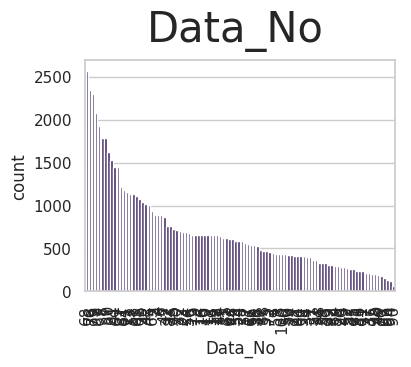





* Variable Analyzed: Dust
* Applied transformation: [] 



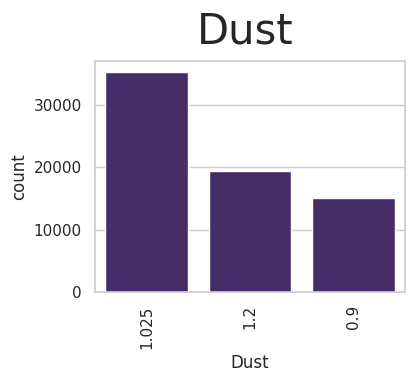

In [8]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

In [9]:
df_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69686 entries, 0 to 69685
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Data_No  69686 non-null  int64  
 1   Dust     69686 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.6+ MB


---

## Numerical transformations

This process can consider transformers like:
* Logarithmic in base e
* Logarithmic in base 10
* Reciprocal
* Power
* BoxCox
* Yeo Johnson

In [10]:
df_total

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
0,1,1.537182,1.046296,0.045257,54.143527,5.5,236.428943,1.025,39.4,0.000000,0.327257,0.242340,13.328682,44.9,99.74
1,1,1.537182,1.242651,0.217247,54.518255,5.6,236.428943,1.025,39.3,0.000000,0.196354,0.242340,13.571021,44.9,99.74
2,1,1.537182,1.360463,0.307825,54.658781,5.7,236.428943,1.025,39.2,0.000000,0.117813,0.242340,13.813361,44.9,99.74
3,1,3.345631,2.154530,0.767573,54.780562,5.8,236.428943,1.025,39.1,1.808449,0.794067,0.242340,14.055701,44.9,99.44
4,1,5.244502,3.390519,1.220983,54.574466,5.9,236.428943,1.025,39.0,1.898871,1.235989,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69681,100,465.494800,457.888170,6.126625,82.675521,52.0,316.985065,1.200,8.2,6.329500,5.071087,0.380382,197.798681,52.4,22.42
69682,100,464.228900,460.424462,6.132149,82.421873,52.1,316.985065,1.200,8.1,-1.265900,2.536292,0.380382,198.179063,52.4,22.63
69683,100,466.037300,462.669597,6.137013,82.743156,52.2,316.985065,1.200,8.0,1.808400,2.245135,0.380382,198.559445,52.4,22.33
69684,100,472.276500,466.512358,6.145285,82.785427,52.3,316.985065,1.200,7.9,6.239200,3.842761,0.380382,198.939827,52.4,21.29


* Step 1: Select variable(s)

In [11]:
variables_engineering = ['Differential_pressure', 'Flow_rate', 'Time', 'Dust_feed', 'Dust', 'mass_g', 'cumulative_mass_g', 'Tt', 'filter_balance']
variables_engineering

['Differential_pressure',
 'Flow_rate',
 'Time',
 'Dust_feed',
 'Dust',
 'mass_g',
 'cumulative_mass_g',
 'Tt',
 'filter_balance']

* Step 2: Create a separate DataFrame, with the variable(s)

In [12]:
df_engineering = df_total[variables_engineering].copy()
df_engineering

,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,mass_g,cumulative_mass_g,Tt,filter_balance
0,1.537182,54.143527,5.5,236.428943,1.025,0.242340,13.328682,44.9,99.74
1,1.537182,54.518255,5.6,236.428943,1.025,0.242340,13.571021,44.9,99.74
2,1.537182,54.658781,5.7,236.428943,1.025,0.242340,13.813361,44.9,99.74
3,3.345631,54.780562,5.8,236.428943,1.025,0.242340,14.055701,44.9,99.44
4,5.244502,54.574466,5.9,236.428943,1.025,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...
69681,465.494800,82.675521,52.0,316.985065,1.200,0.380382,197.798681,52.4,22.42
69682,464.228900,82.421873,52.1,316.985065,1.200,0.380382,198.179063,52.4,22.63
69683,466.037300,82.743156,52.2,316.985065,1.200,0.380382,198.559445,52.4,22.33
69684,472.276500,82.785427,52.3,316.985065,1.200,0.380382,198.939827,52.4,21.29


Step 3: 
* Create engineered variables(s) by applying the transformation(s)
* Assess engineered variables distribution and 
* Select the most suitable method

* Variable Analyzed: Differential_pressure
* Applied transformation: ['Differential_pressure_power', 'Differential_pressure_yeo_johnson'] 



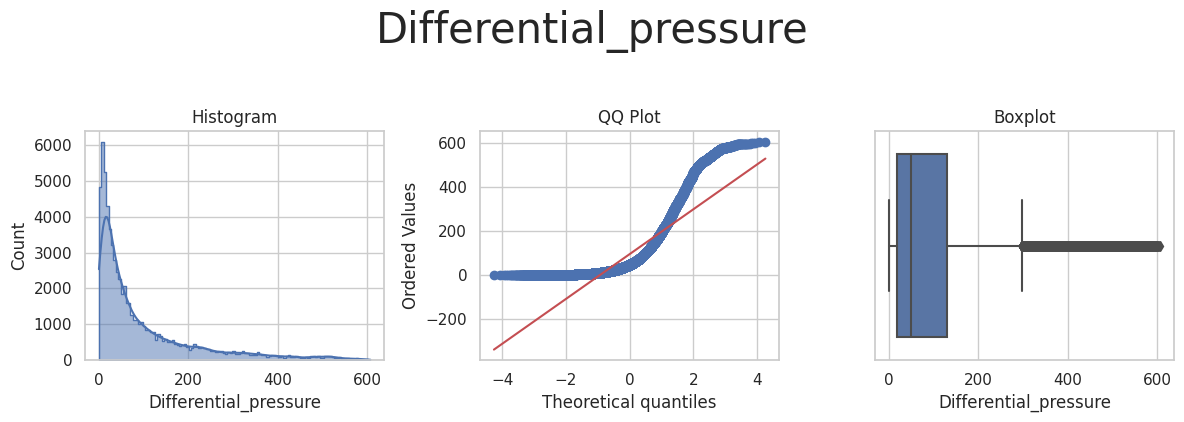

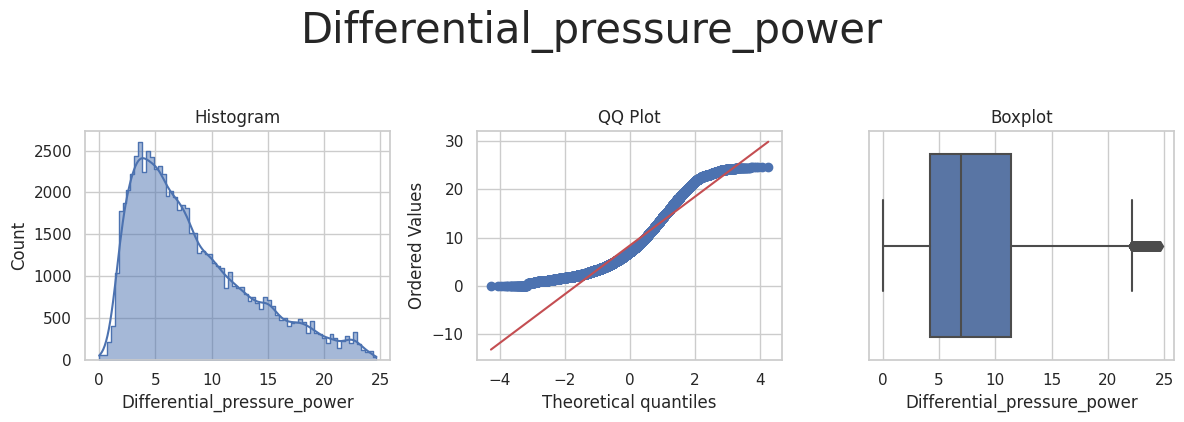

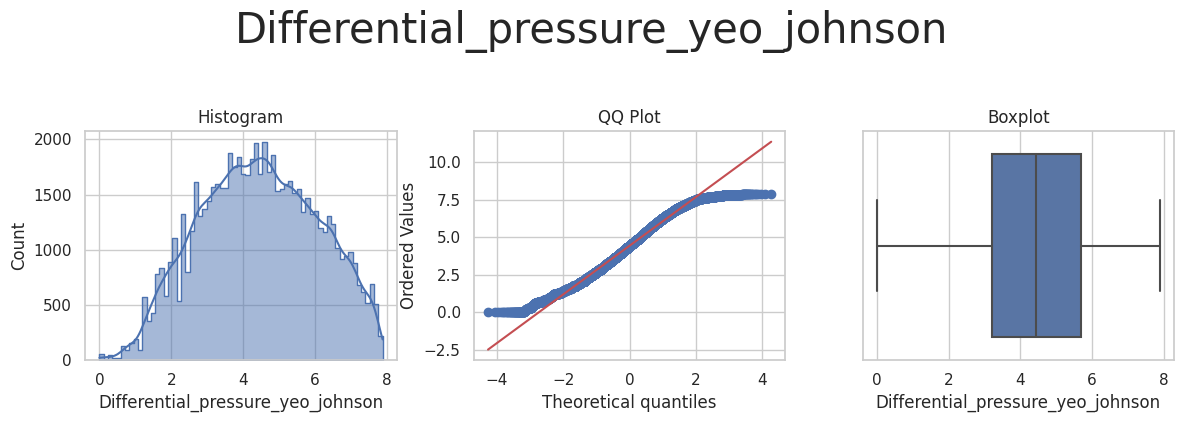



* Variable Analyzed: Flow_rate
* Applied transformation: ['Flow_rate_log_e', 'Flow_rate_log_10', 'Flow_rate_reciprocal', 'Flow_rate_power', 'Flow_rate_box_cox', 'Flow_rate_yeo_johnson'] 



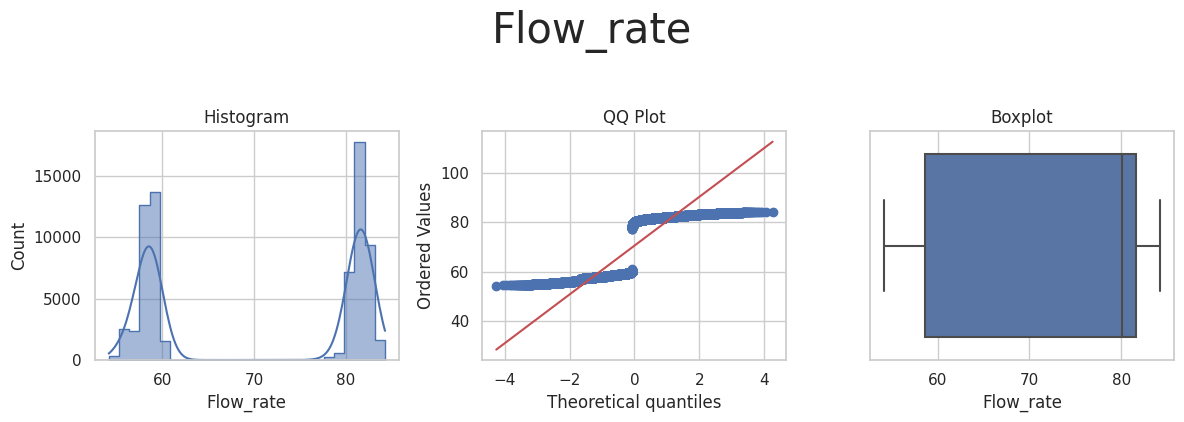

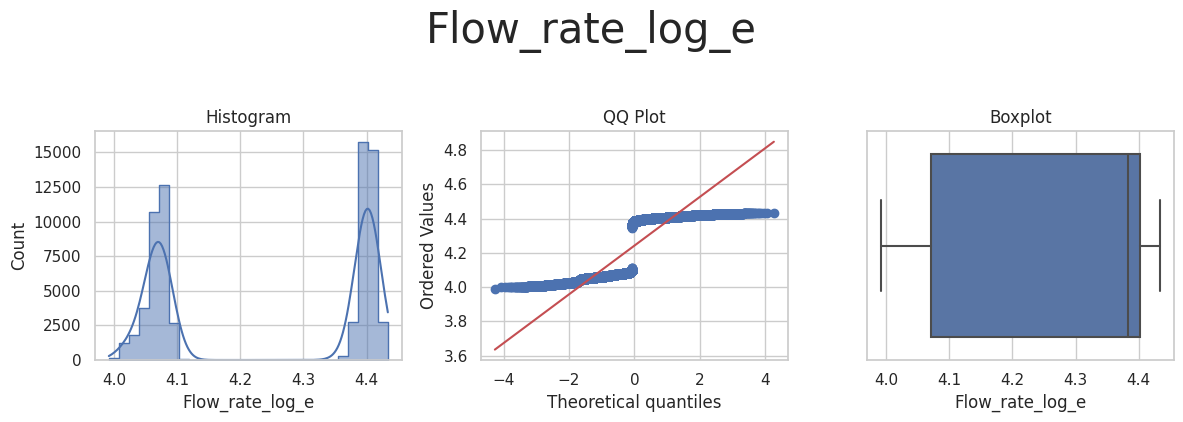

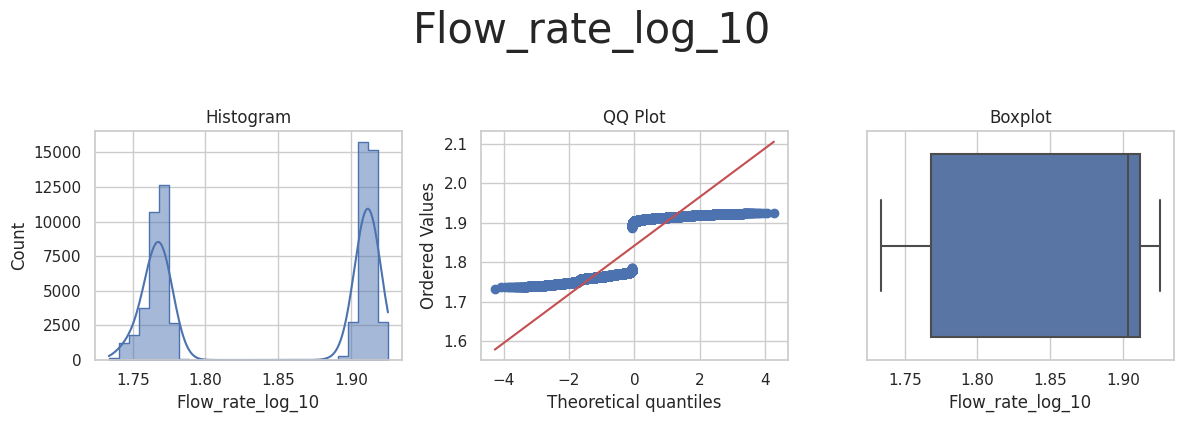

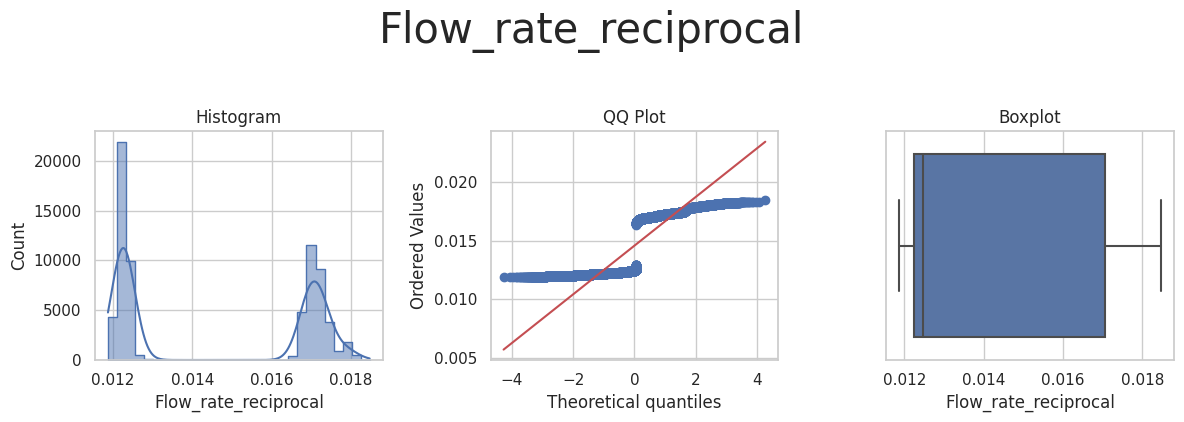

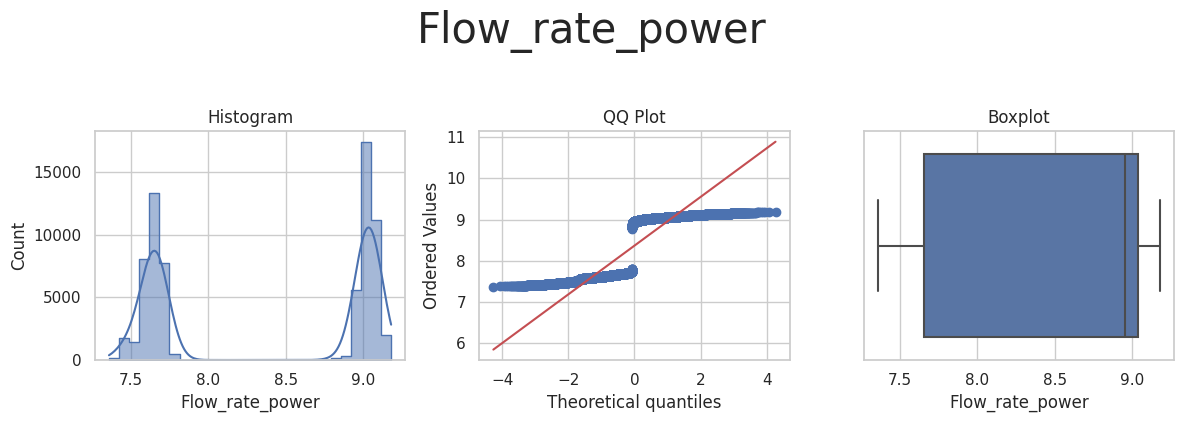

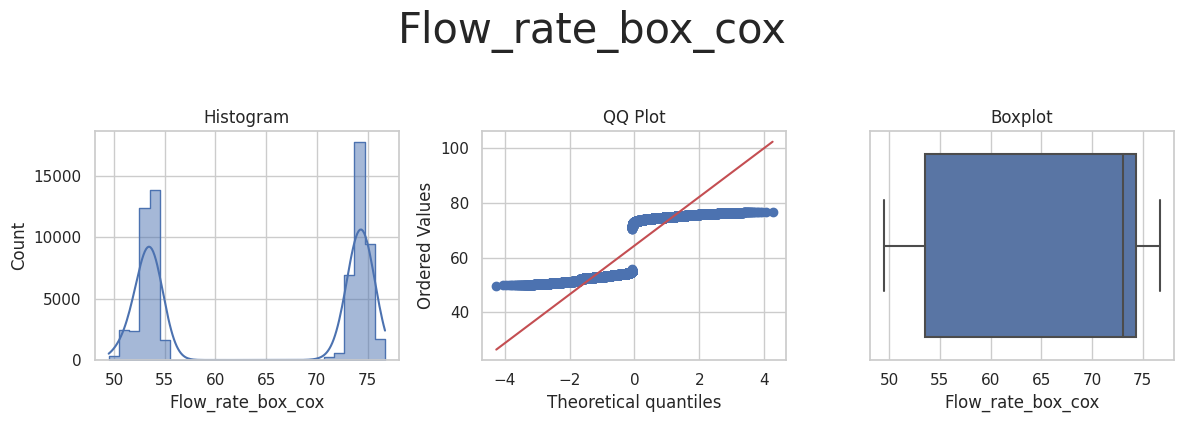

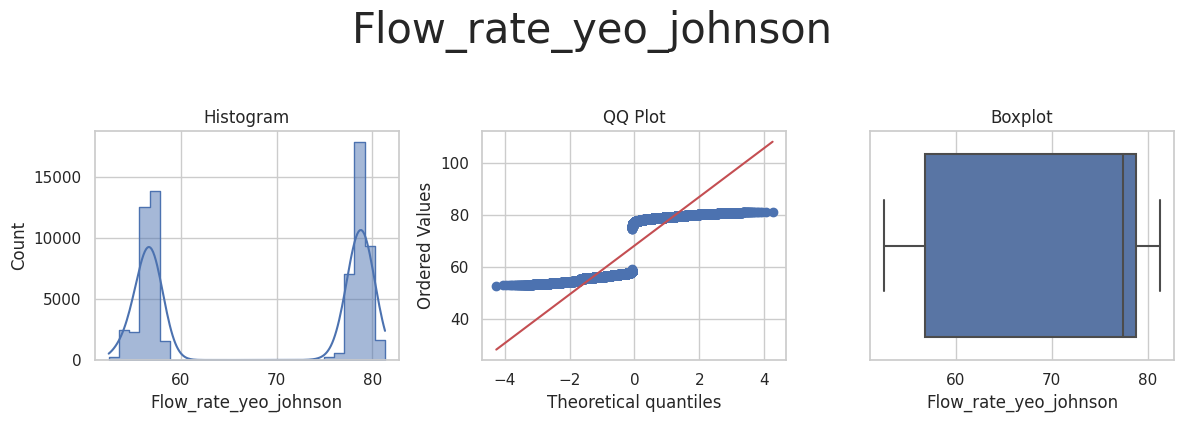



* Variable Analyzed: Time
* Applied transformation: ['Time_log_e', 'Time_log_10', 'Time_reciprocal', 'Time_power', 'Time_box_cox', 'Time_yeo_johnson'] 



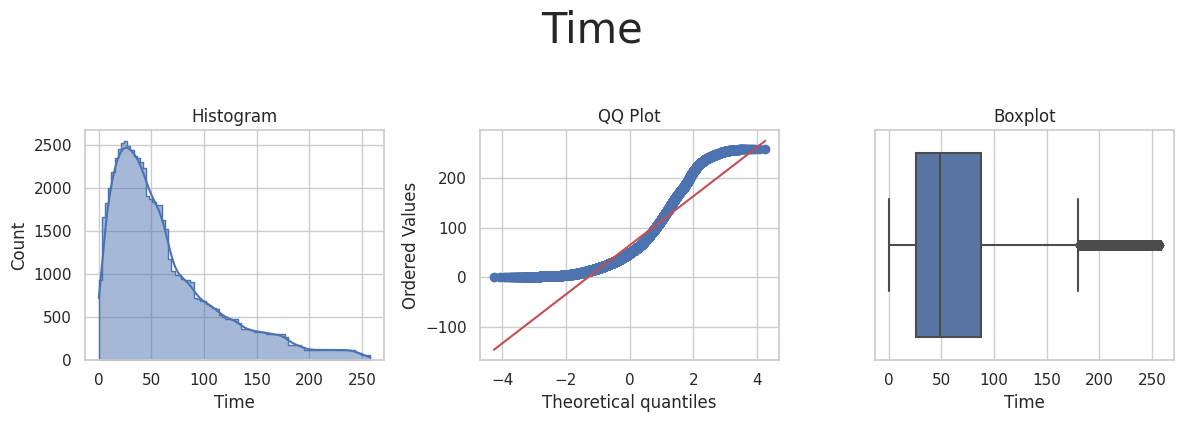

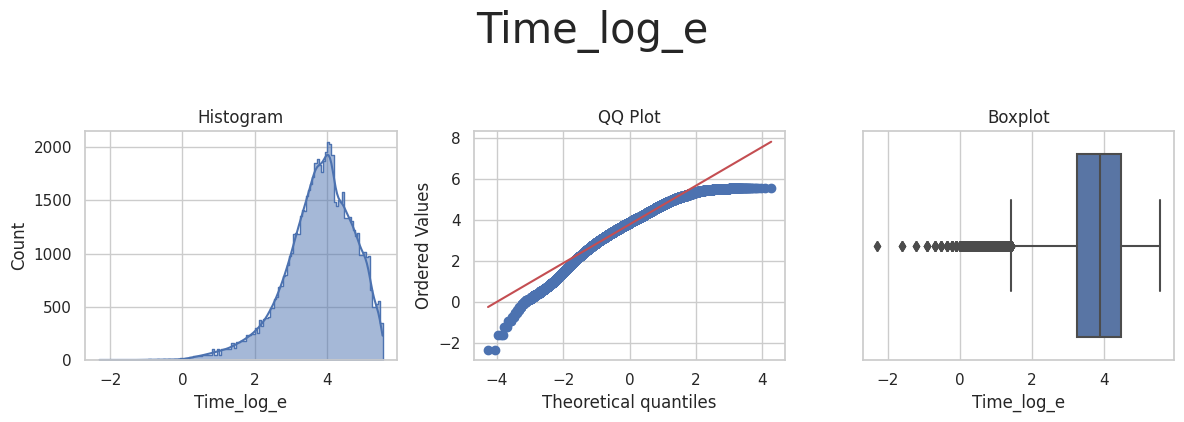

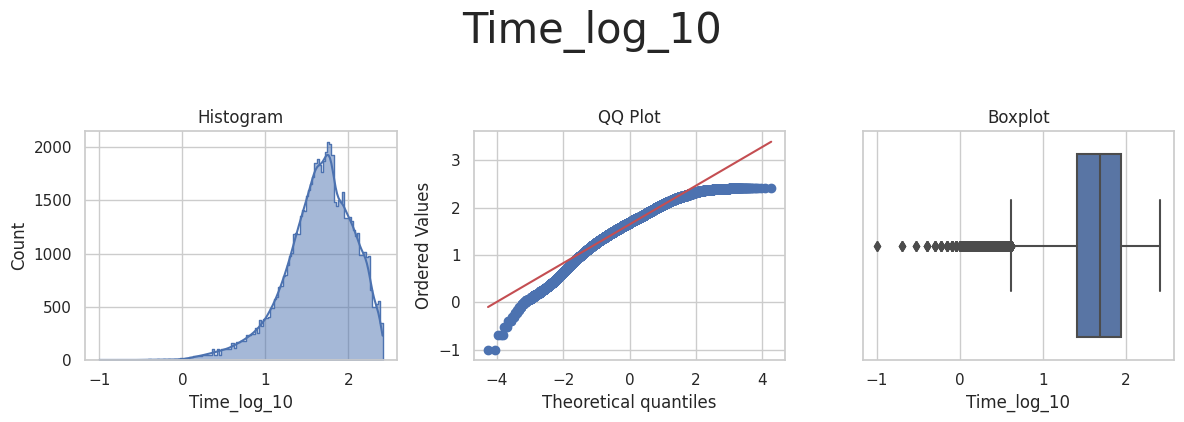

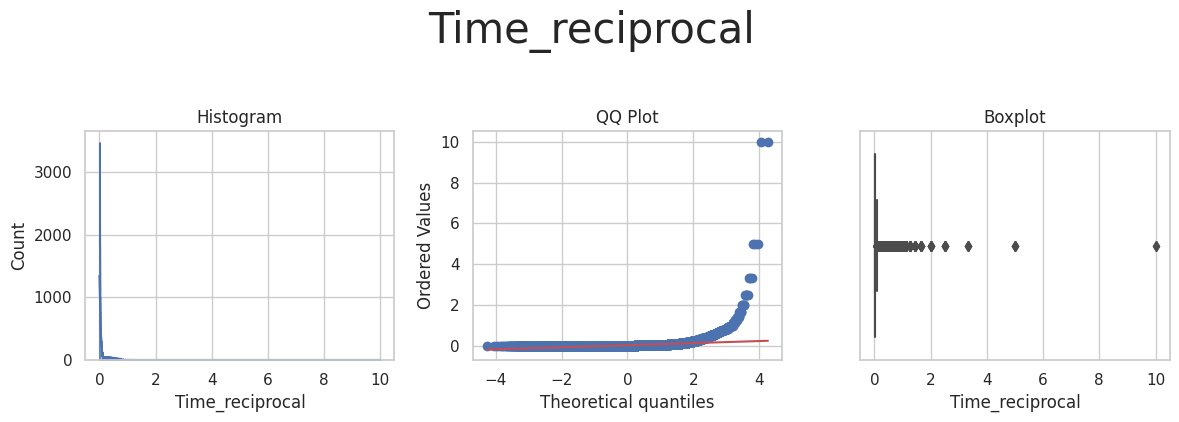

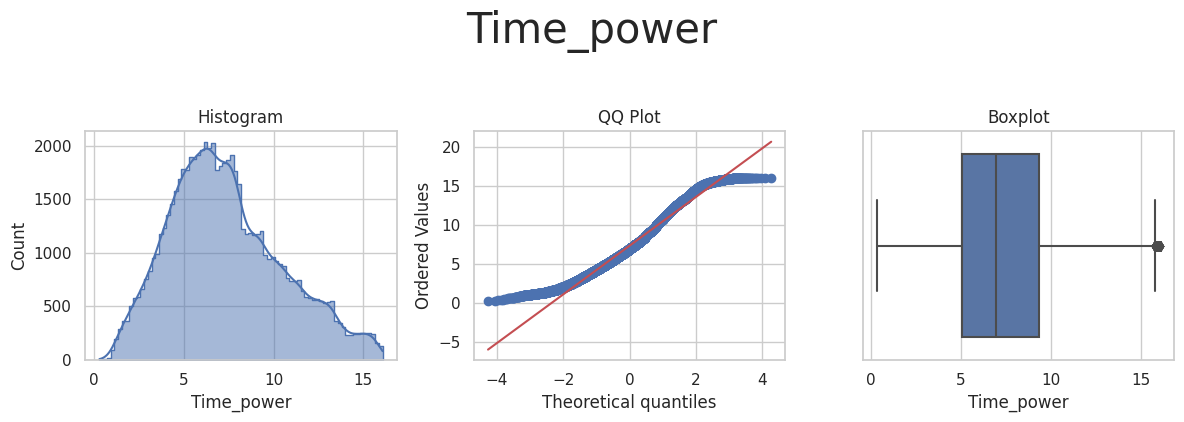

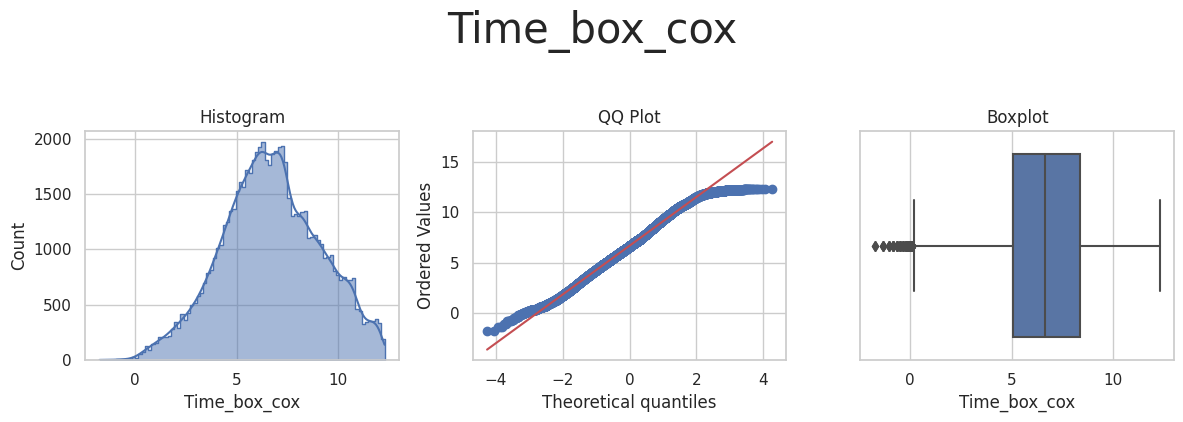

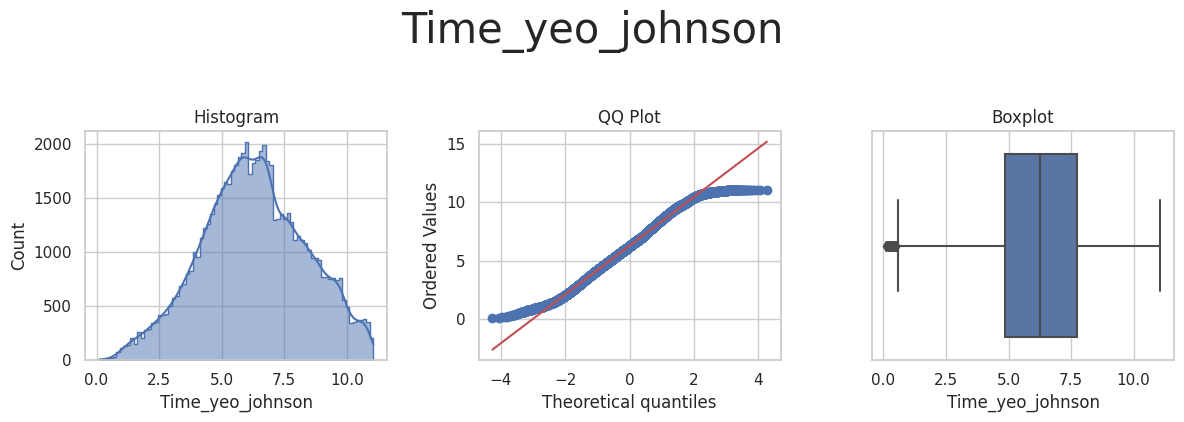



* Variable Analyzed: Dust_feed
* Applied transformation: ['Dust_feed_log_e', 'Dust_feed_log_10', 'Dust_feed_reciprocal', 'Dust_feed_power', 'Dust_feed_box_cox', 'Dust_feed_yeo_johnson'] 



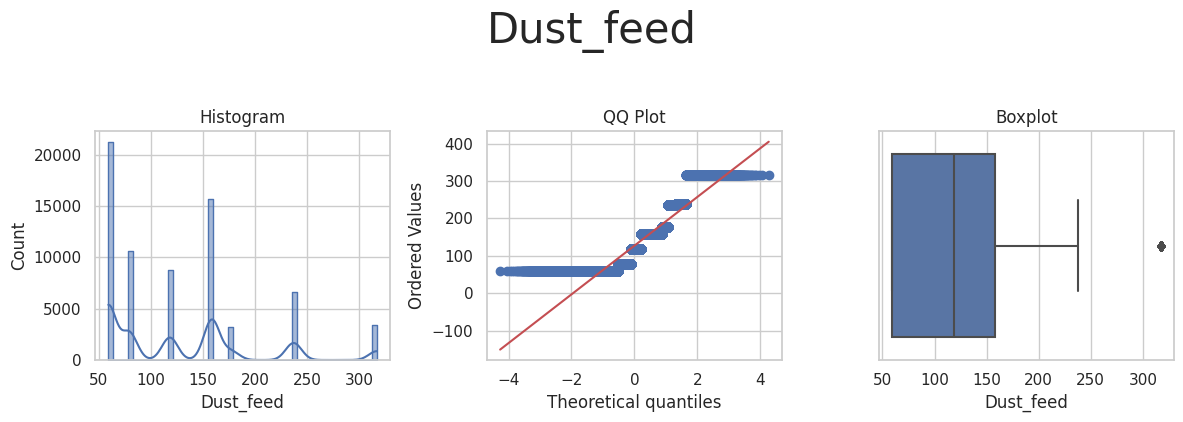

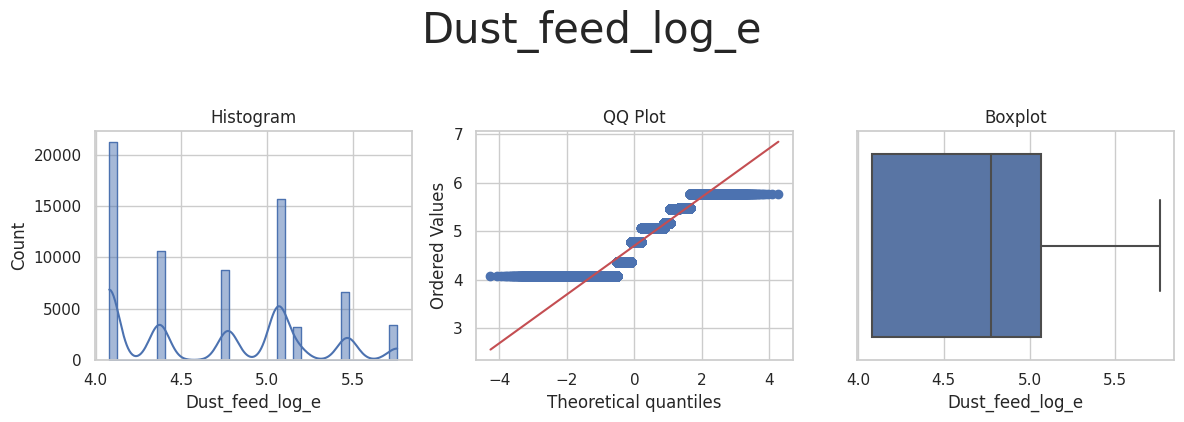

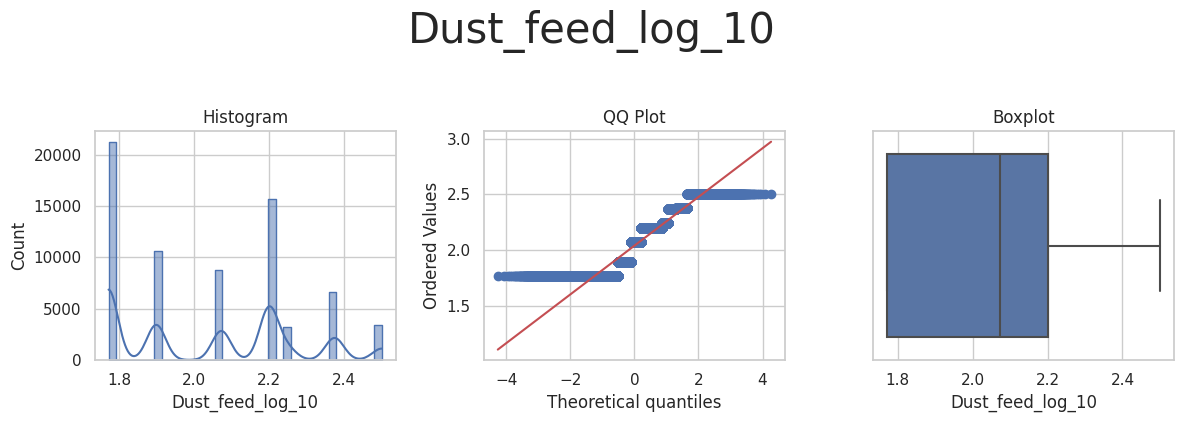

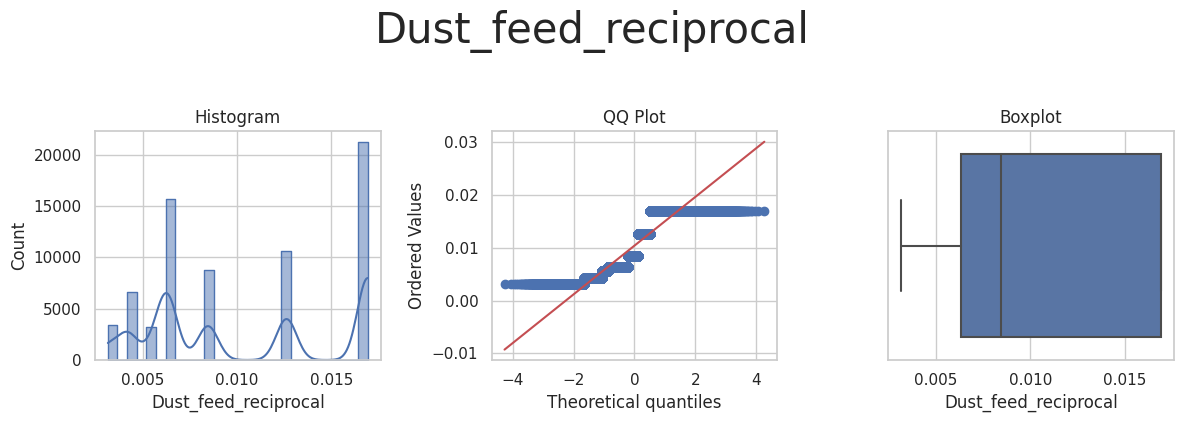

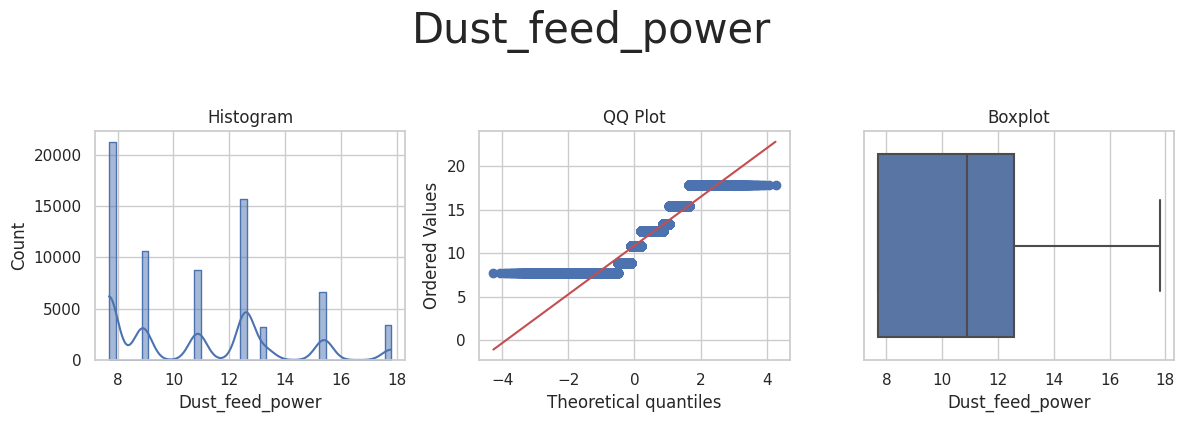

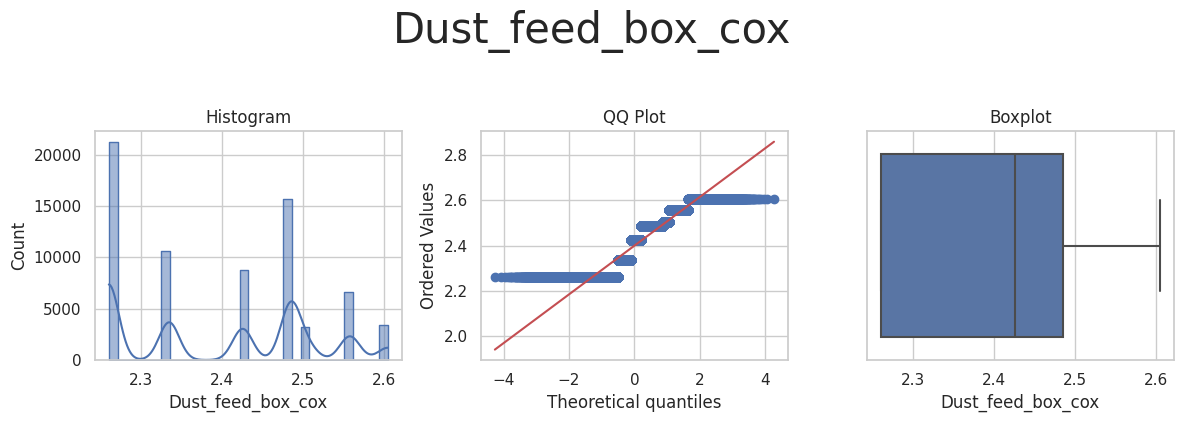

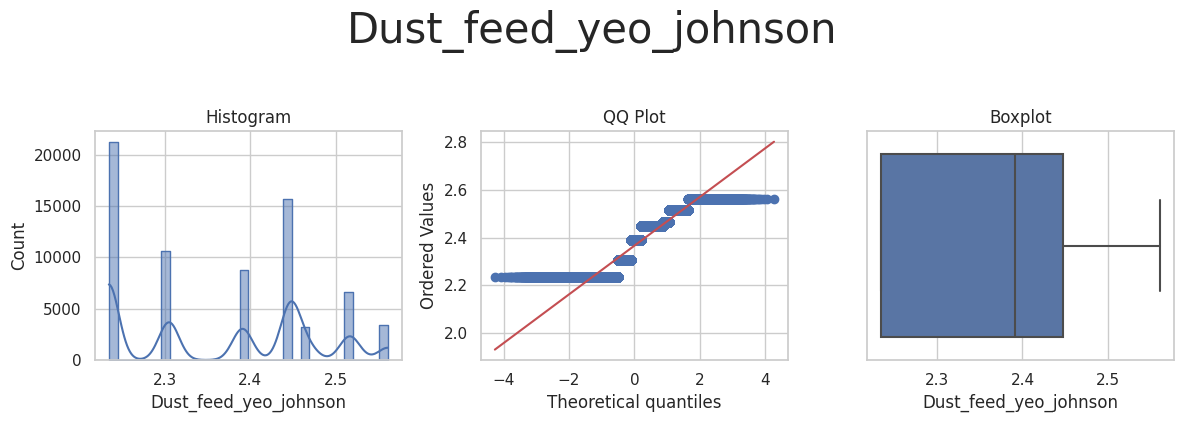



* Variable Analyzed: Dust
* Applied transformation: ['Dust_log_e', 'Dust_log_10', 'Dust_reciprocal', 'Dust_power', 'Dust_box_cox', 'Dust_yeo_johnson'] 



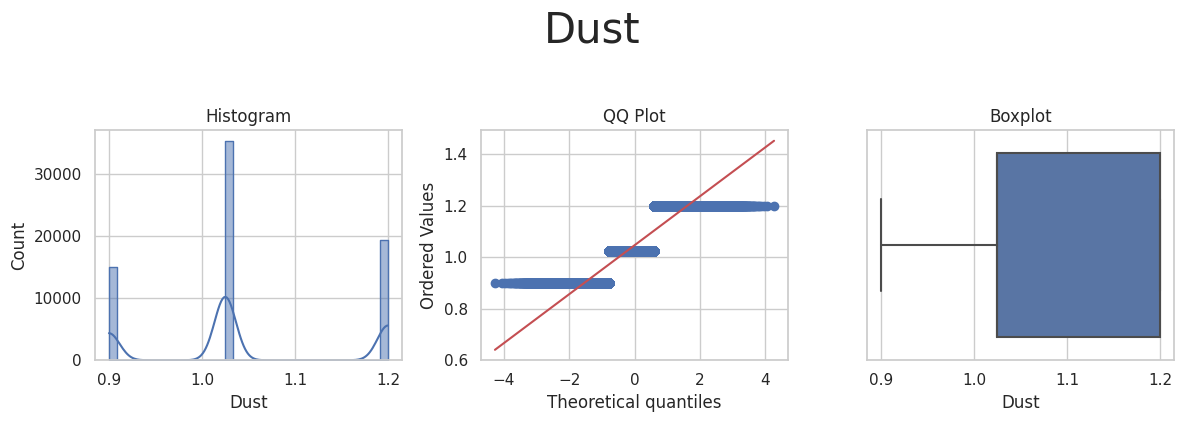

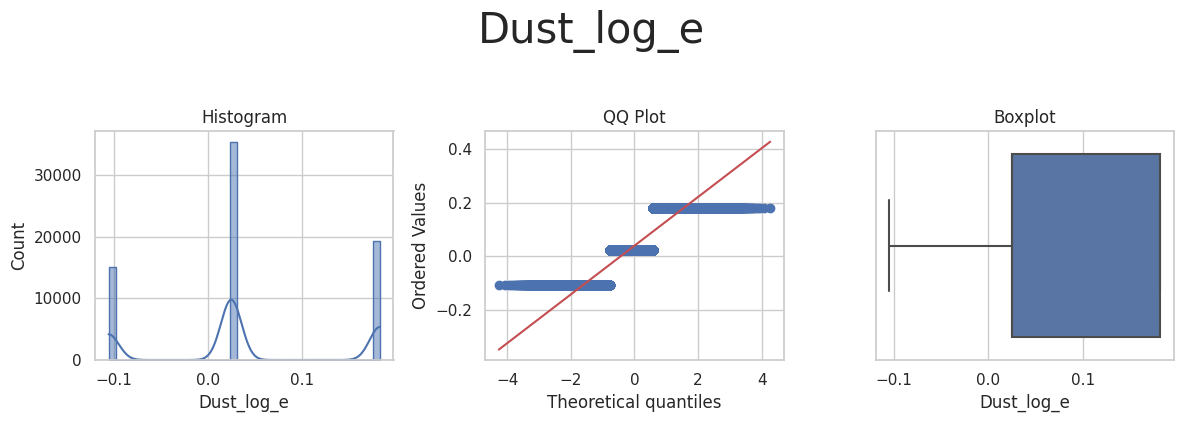

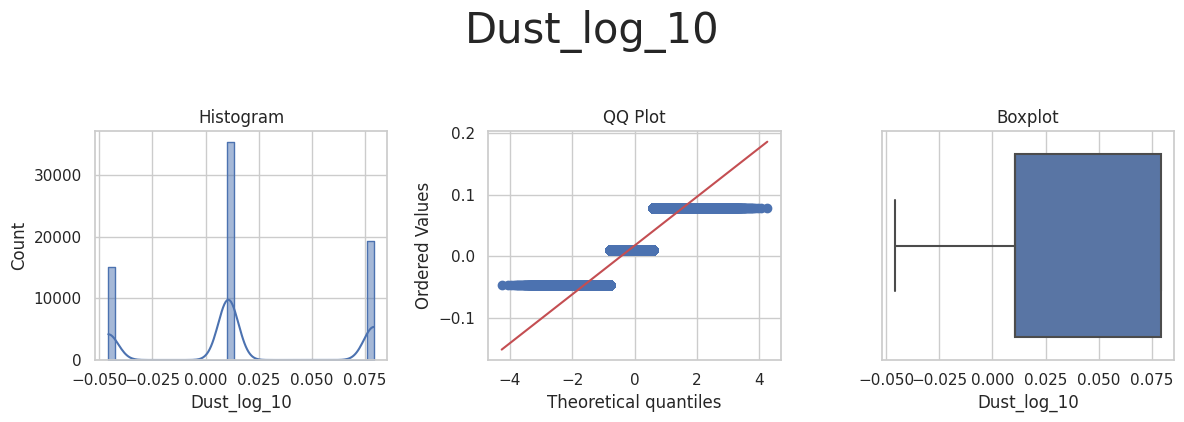

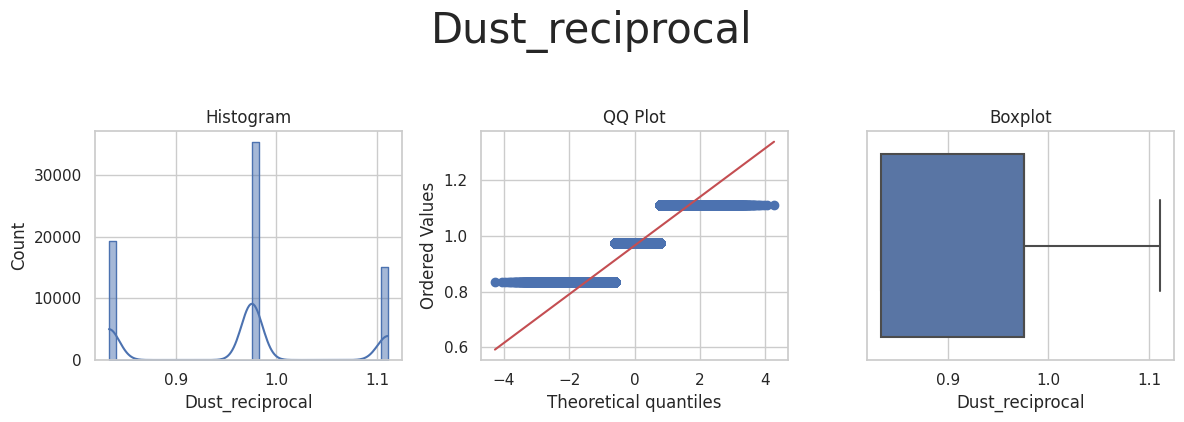

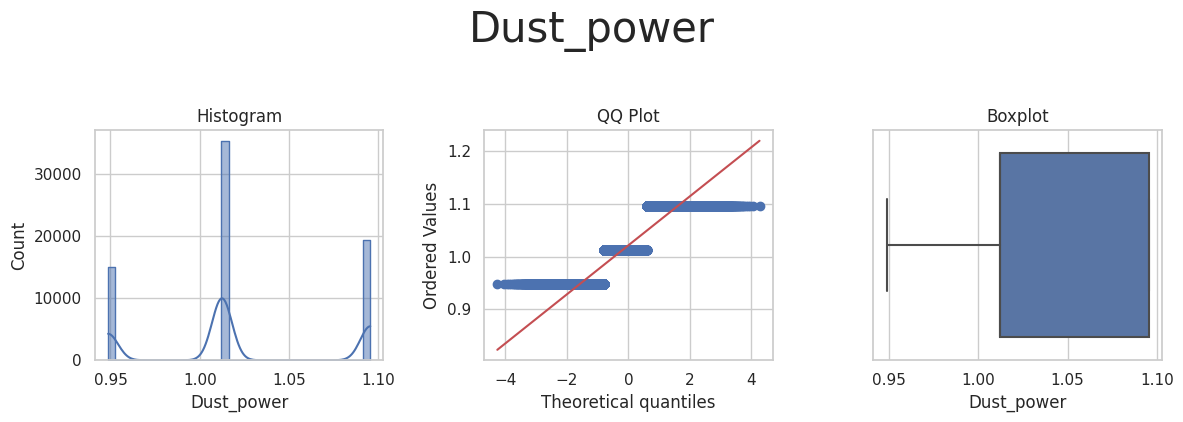

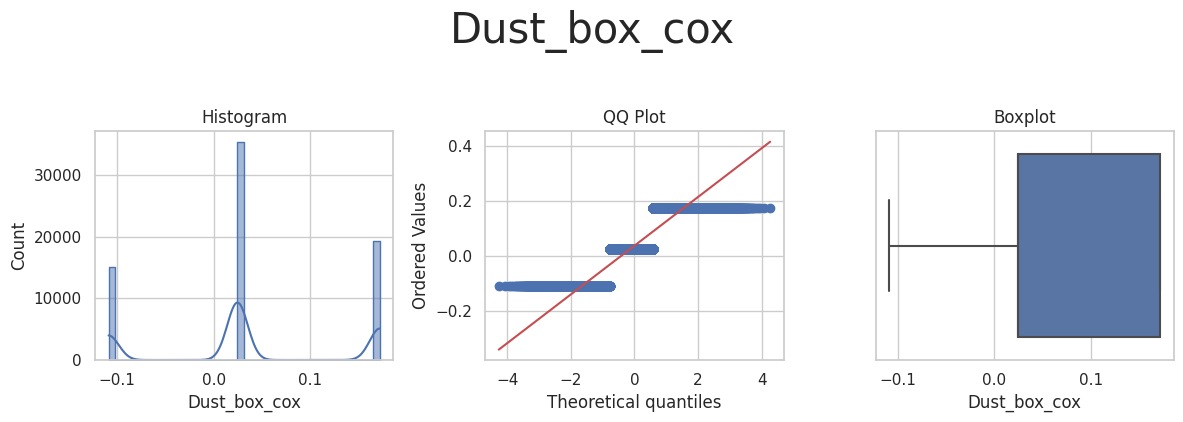

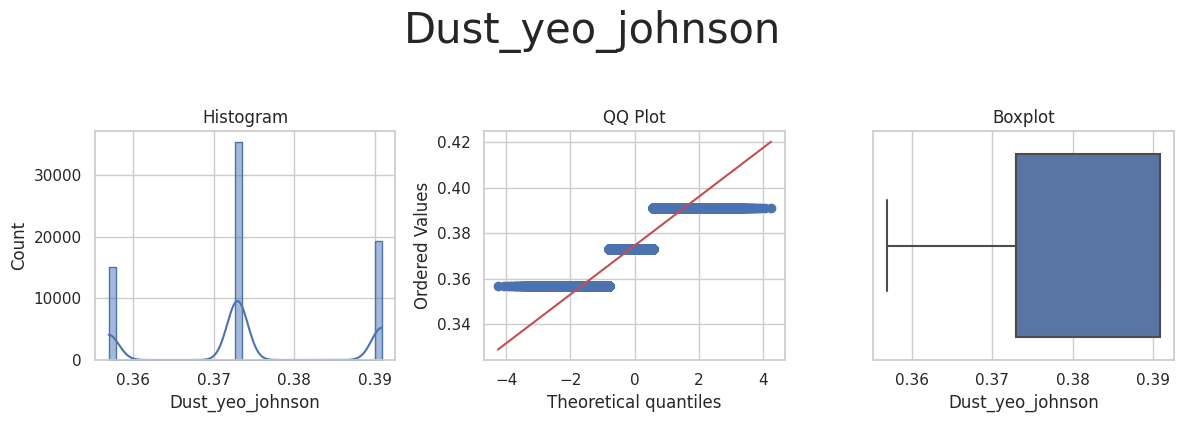



* Variable Analyzed: mass_g
* Applied transformation: ['mass_g_log_e', 'mass_g_log_10', 'mass_g_reciprocal', 'mass_g_power', 'mass_g_box_cox', 'mass_g_yeo_johnson'] 



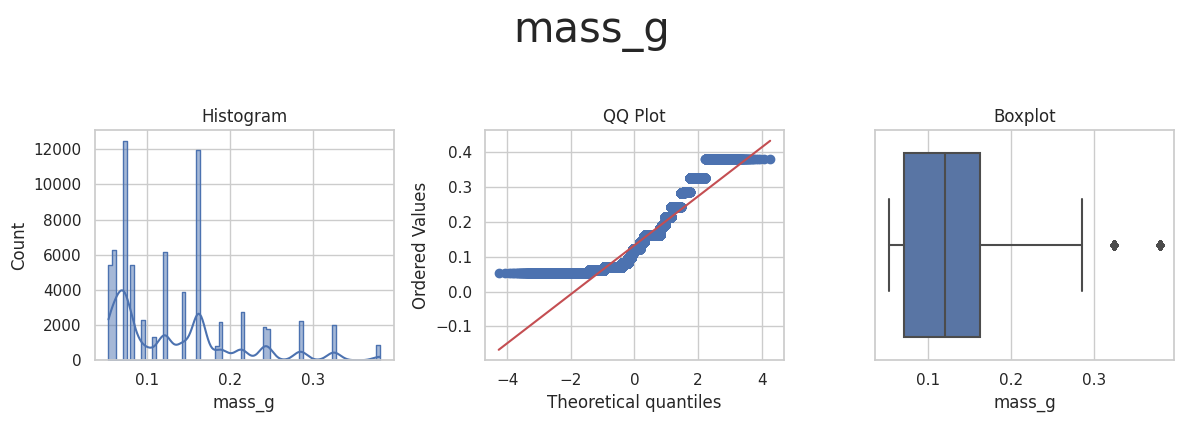

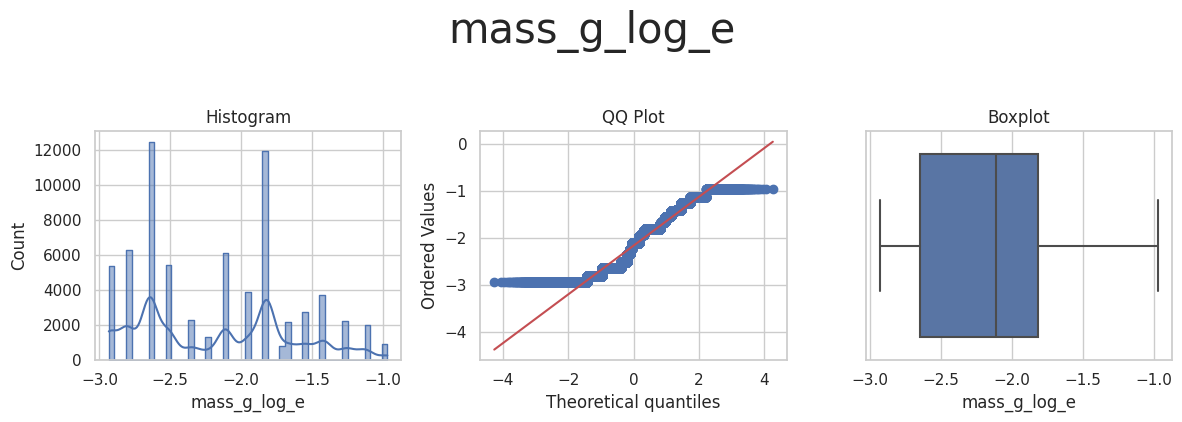

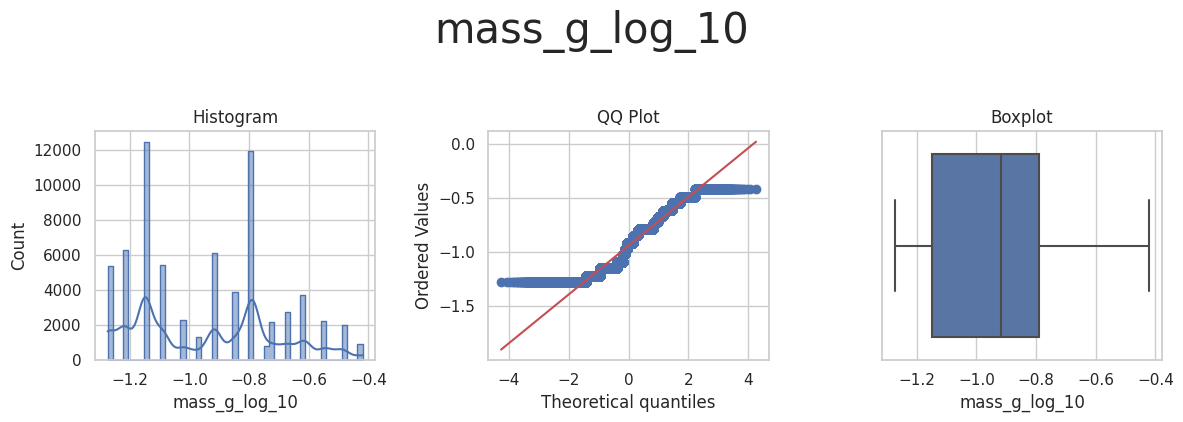

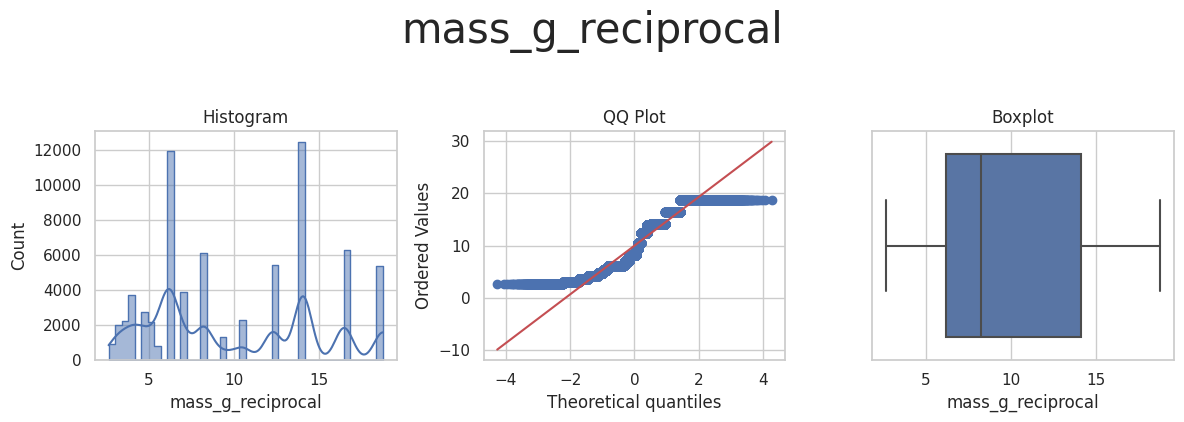

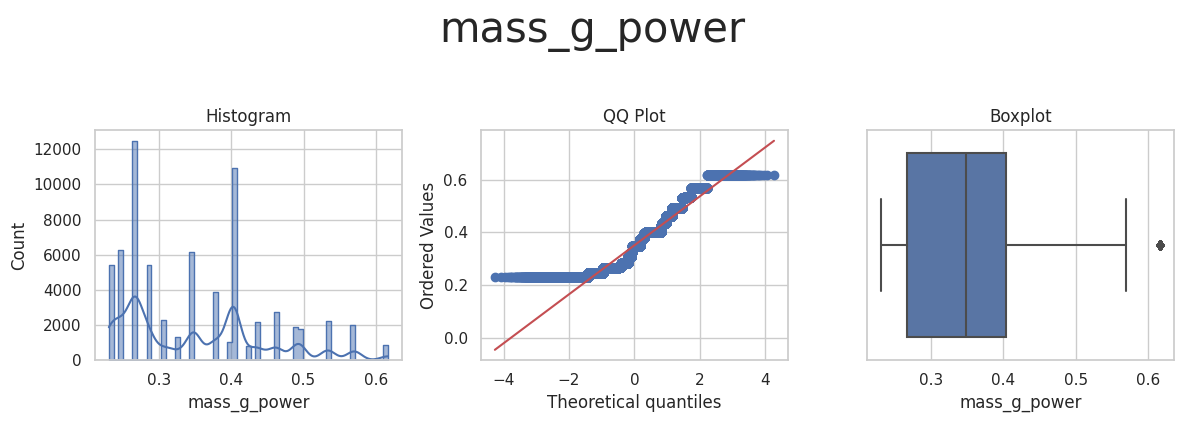

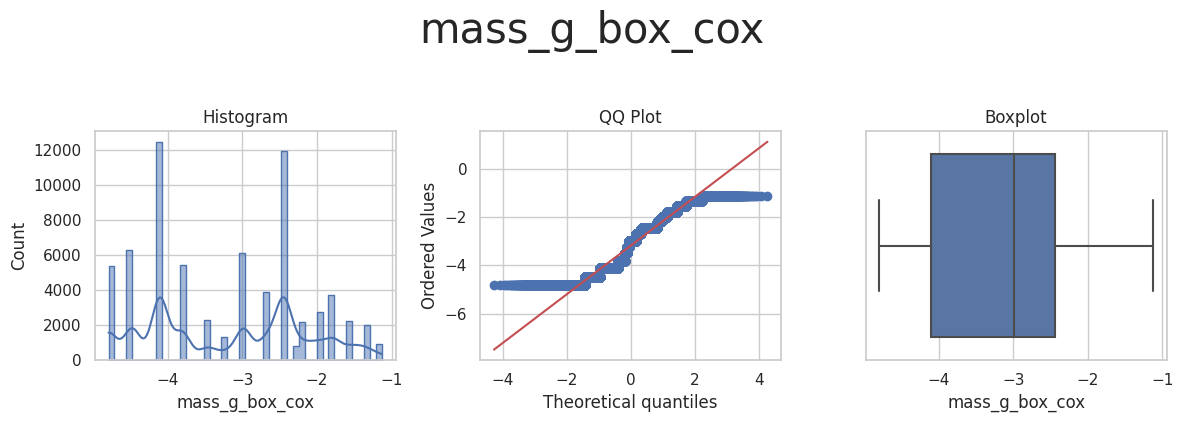

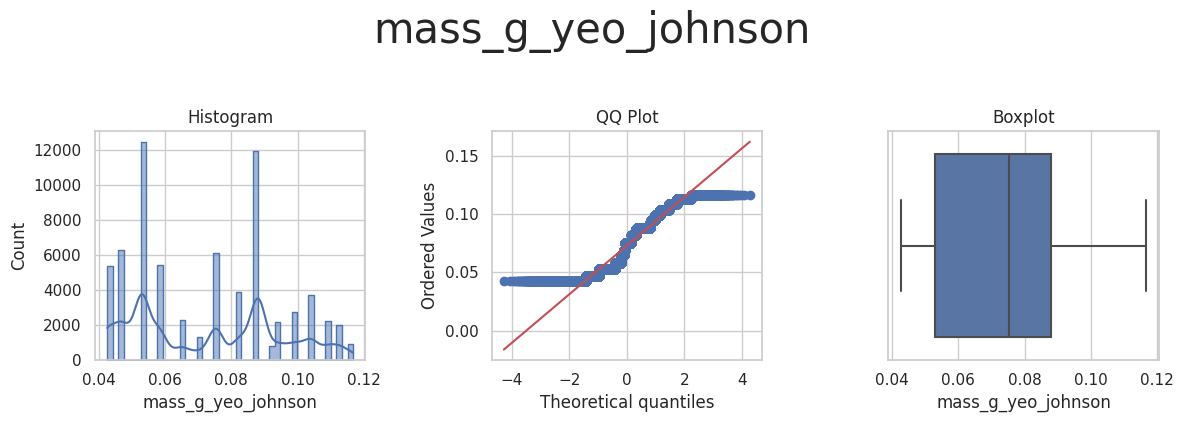



* Variable Analyzed: cumulative_mass_g
* Applied transformation: ['cumulative_mass_g_log_e', 'cumulative_mass_g_log_10', 'cumulative_mass_g_reciprocal', 'cumulative_mass_g_power', 'cumulative_mass_g_box_cox', 'cumulative_mass_g_yeo_johnson'] 



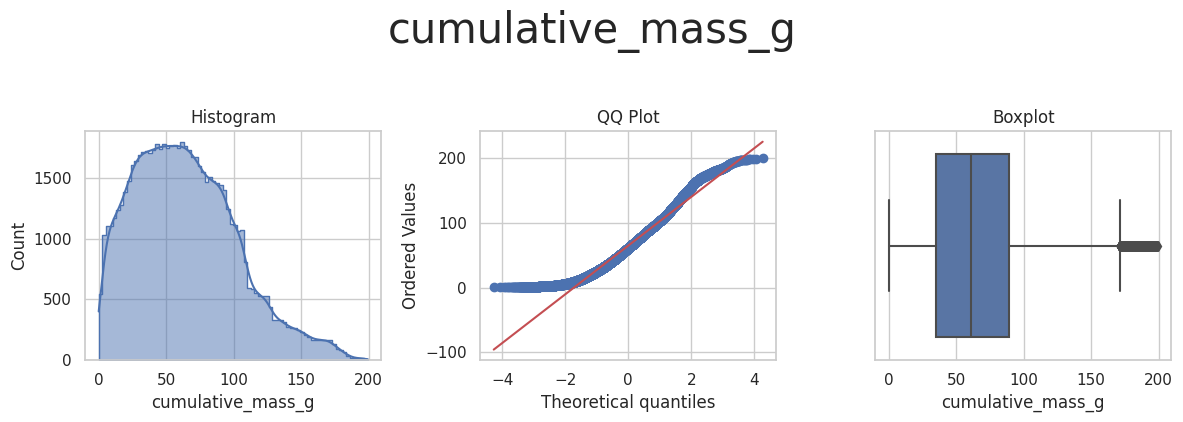

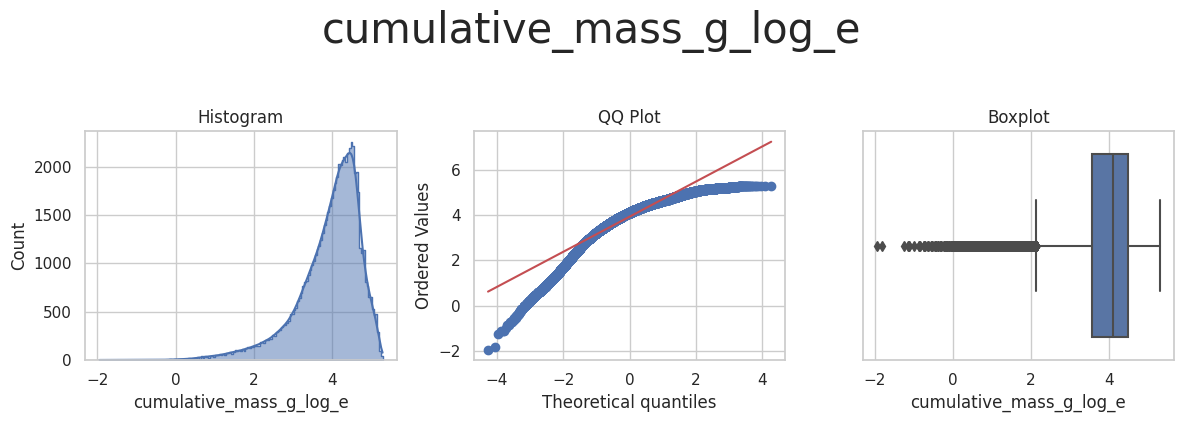

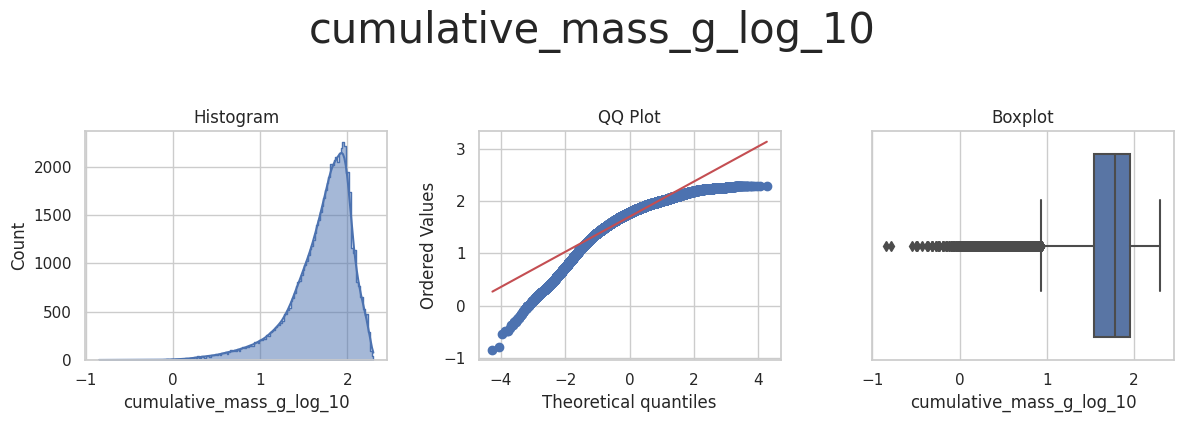

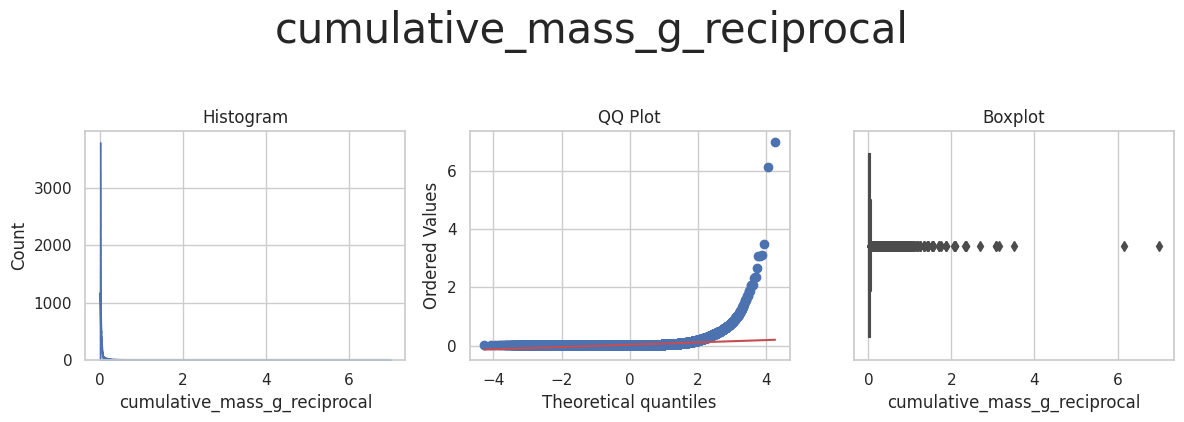

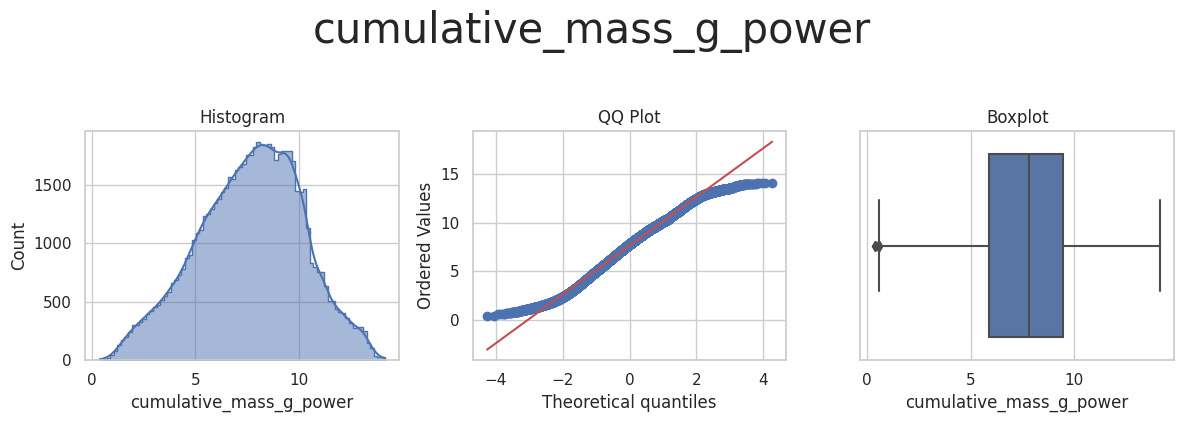

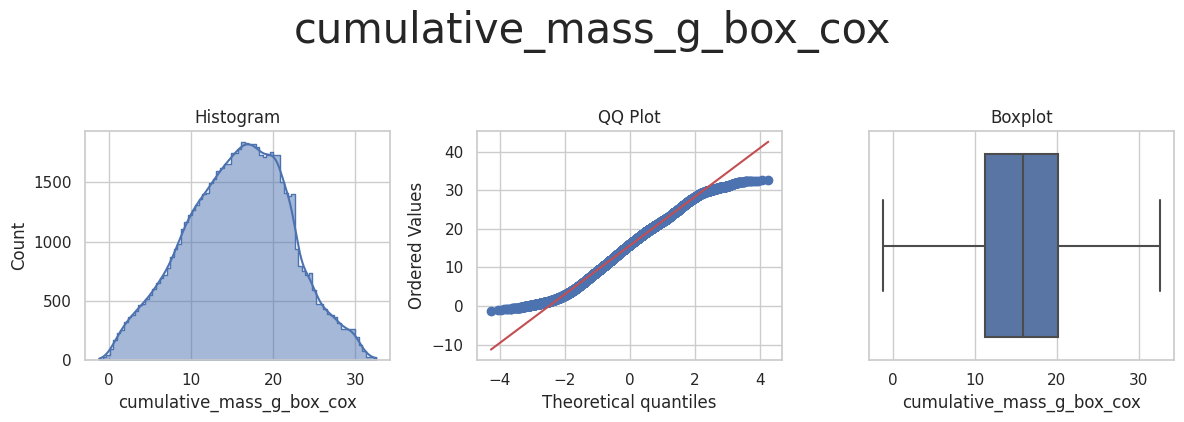

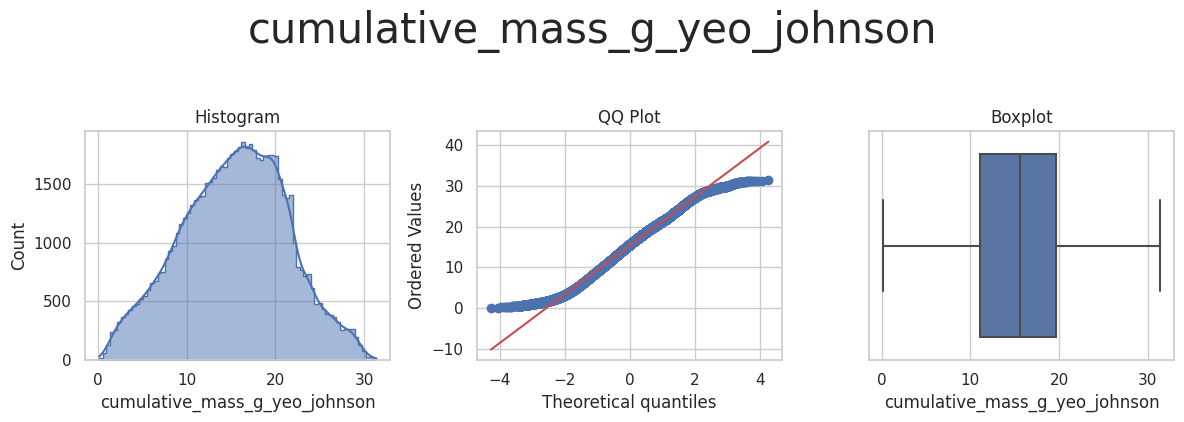



* Variable Analyzed: Tt
* Applied transformation: ['Tt_log_e', 'Tt_log_10', 'Tt_reciprocal', 'Tt_power', 'Tt_box_cox', 'Tt_yeo_johnson'] 



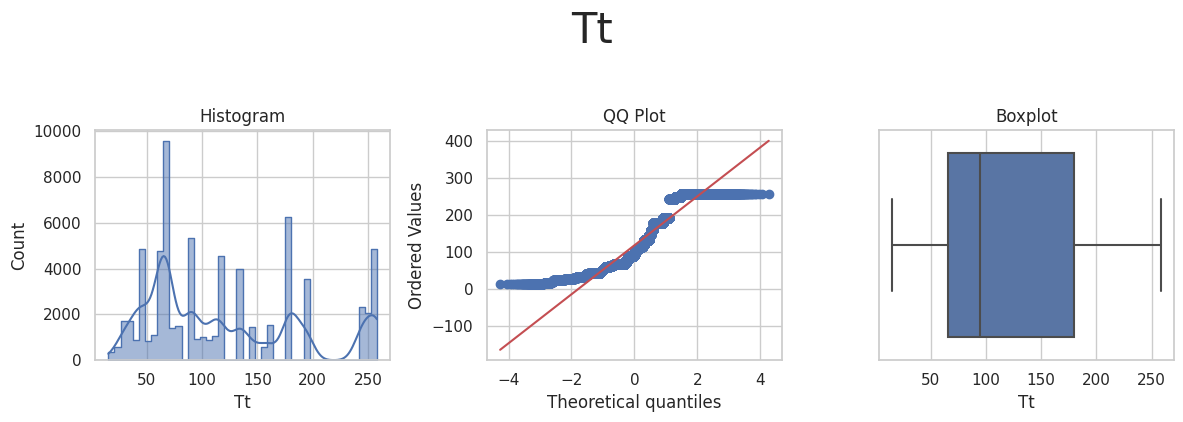

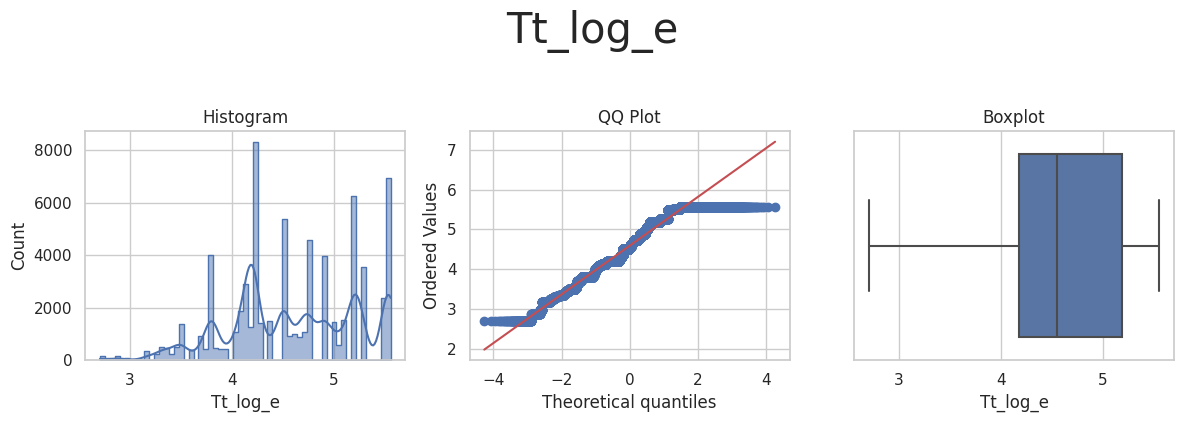

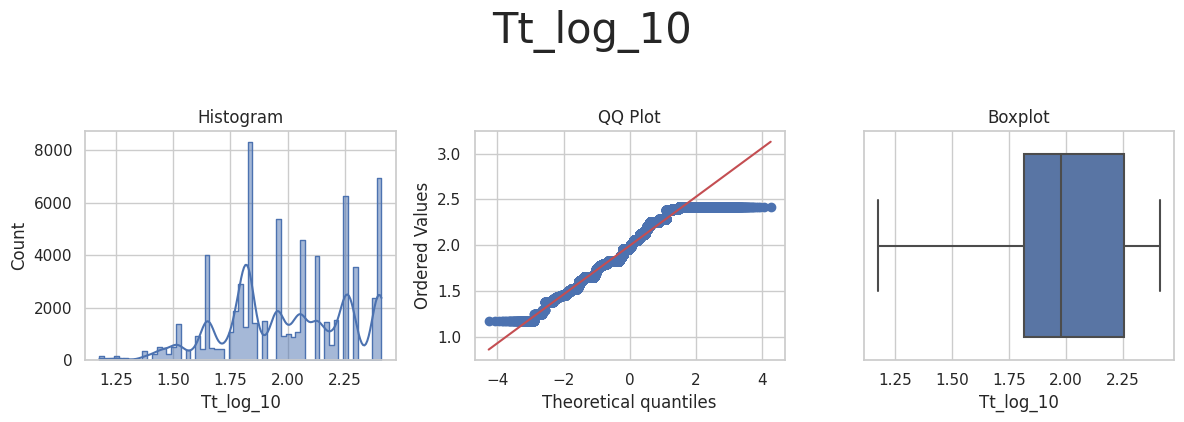

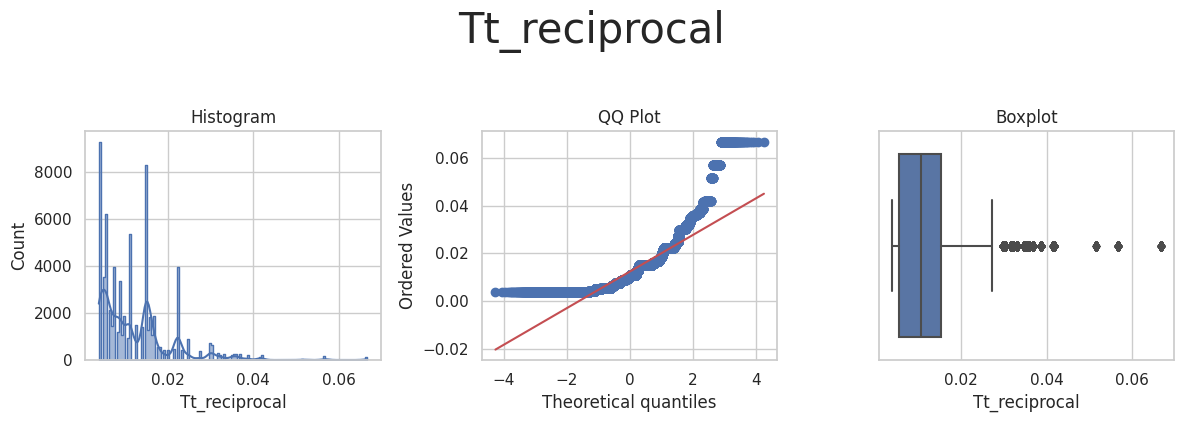

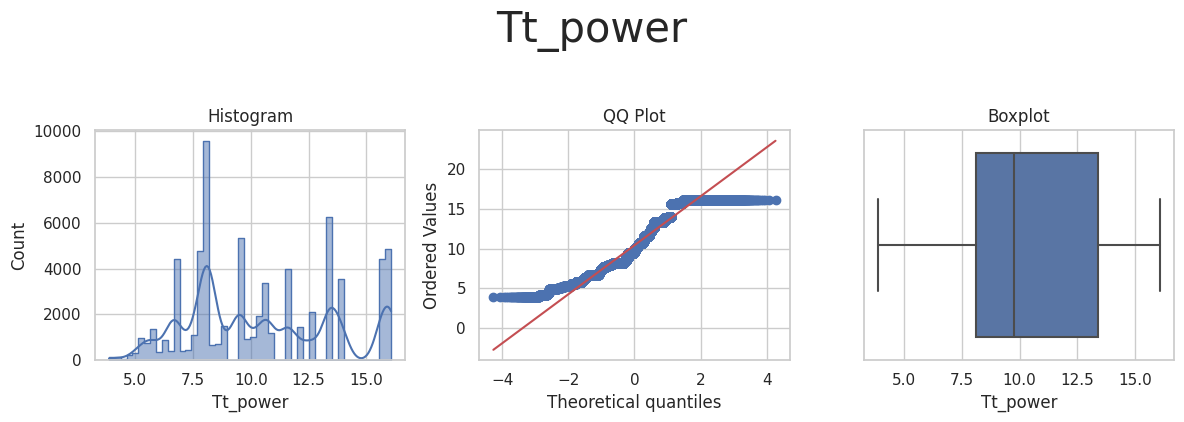

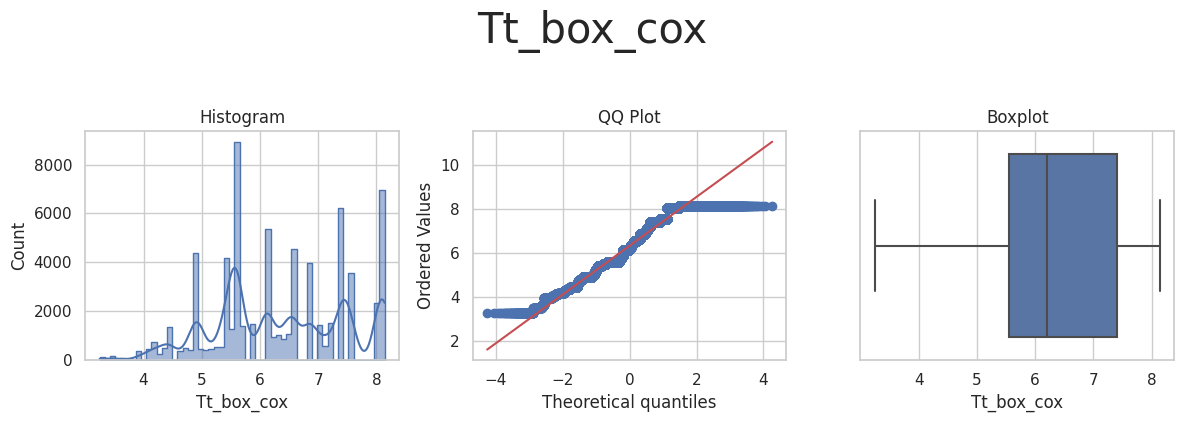

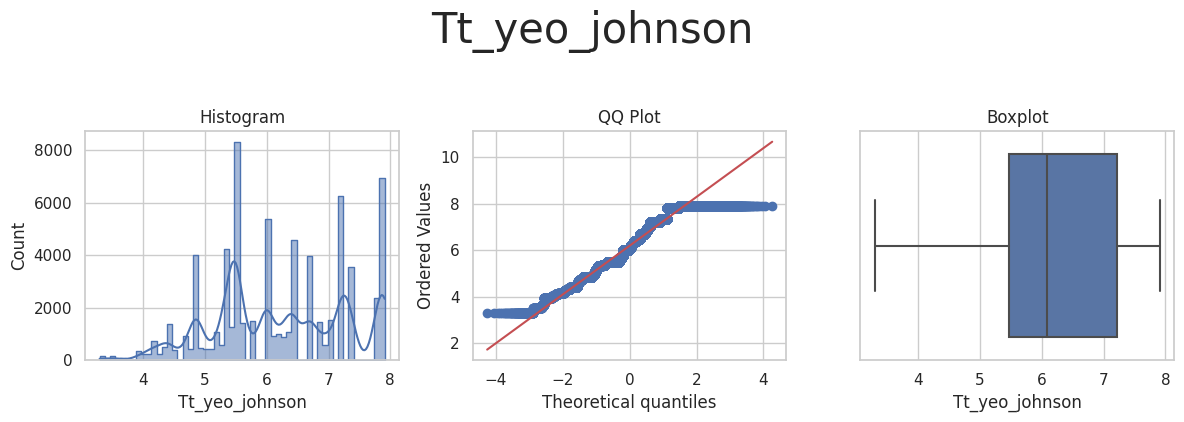



* Variable Analyzed: filter_balance
* Applied transformation: ['filter_balance_reciprocal', 'filter_balance_power', 'filter_balance_yeo_johnson'] 



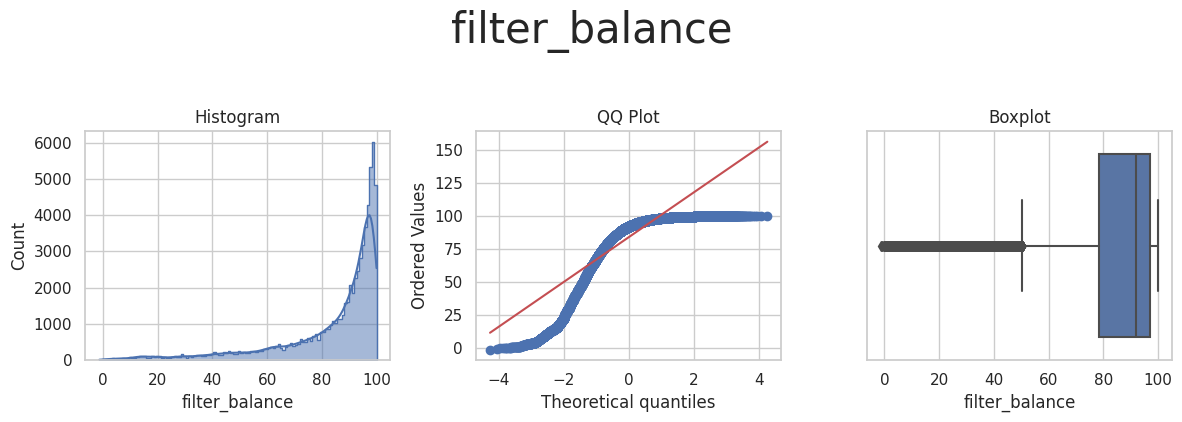

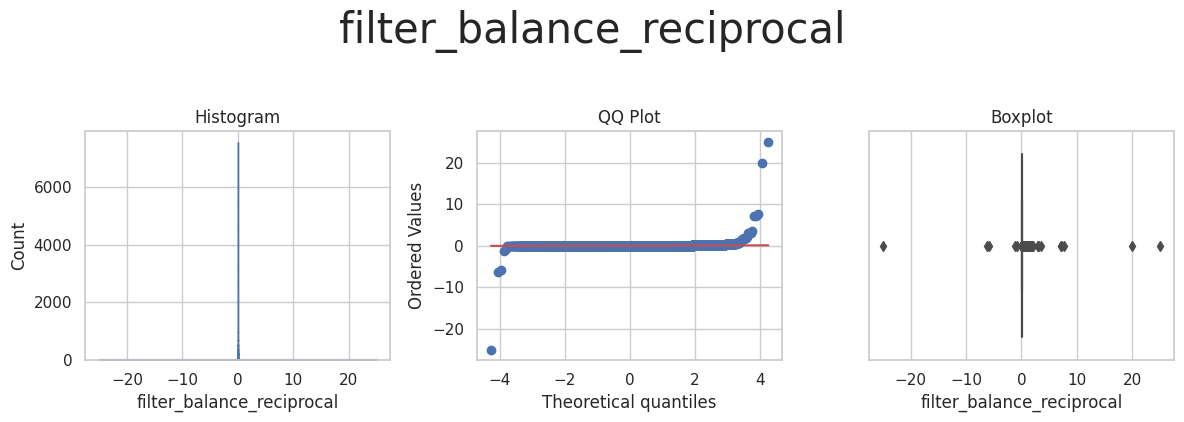

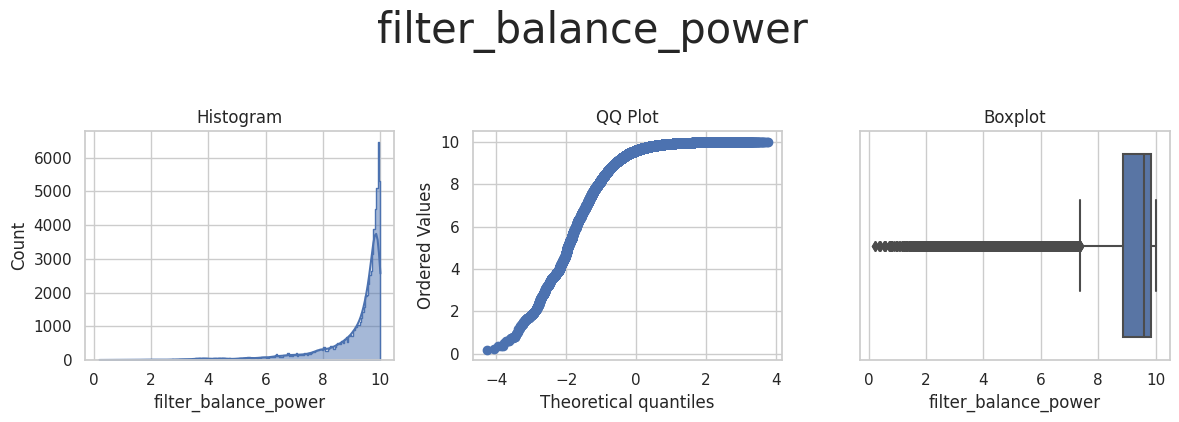

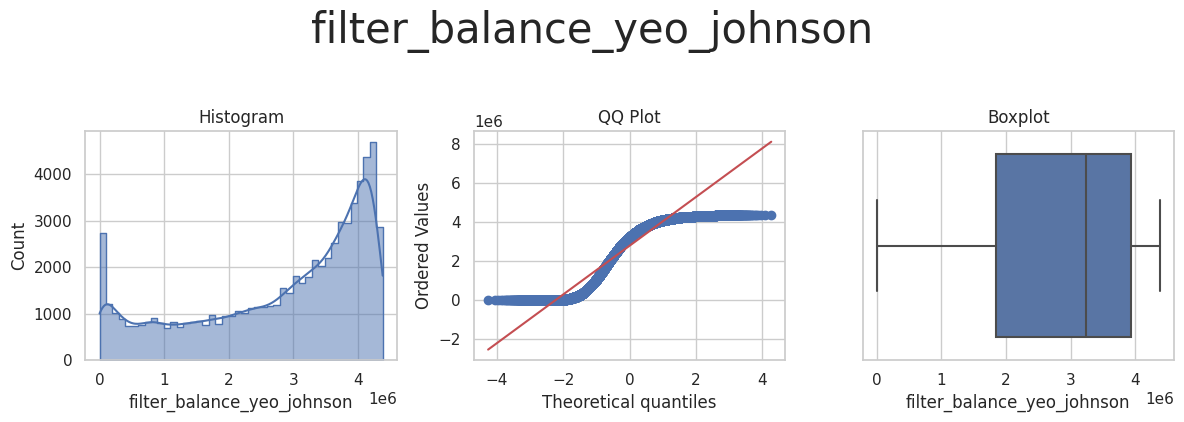

In [13]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

## SmartCorrelatedSelection Variables

Looking for groups of features that correlate amongst themselves and remove any surplus correlated features since they add the same information to the model.
The transformer finds the groups and drops the features based on the **method**, **threshold** and **selection** method.
For every group of correlated features, the transformer will remove all but one feature.

* Step 1: Create a separate DataFrame, with the variable(s)

In [14]:
df_engineering = df_total.copy().drop(labels=['4point_EWM', 'change_DP', 'change_EWM'], axis=1)
df_engineering

,Data_No,Differential_pressure,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
0,1,1.537182,0.045257,54.143527,5.5,236.428943,1.025,39.4,0.242340,13.328682,44.9,99.74
1,1,1.537182,0.217247,54.518255,5.6,236.428943,1.025,39.3,0.242340,13.571021,44.9,99.74
2,1,1.537182,0.307825,54.658781,5.7,236.428943,1.025,39.2,0.242340,13.813361,44.9,99.74
3,1,3.345631,0.767573,54.780562,5.8,236.428943,1.025,39.1,0.242340,14.055701,44.9,99.44
4,1,5.244502,1.220983,54.574466,5.9,236.428943,1.025,39.0,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...
69681,100,465.494800,6.126625,82.675521,52.0,316.985065,1.200,8.2,0.380382,197.798681,52.4,22.42
69682,100,464.228900,6.132149,82.421873,52.1,316.985065,1.200,8.1,0.380382,198.179063,52.4,22.63
69683,100,466.037300,6.137013,82.743156,52.2,316.985065,1.200,8.0,0.380382,198.559445,52.4,22.33
69684,100,472.276500,6.145285,82.785427,52.3,316.985065,1.200,7.9,0.380382,198.939827,52.4,21.29


* Step 2: Create engineered variables(s) applying the transformation(s)

In [15]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
print('Correlated Variables :\n', corr_sel.correlated_feature_sets_)
print('\nFeatures to Drop :\n', corr_sel.features_to_drop_)

Correlated Variables :
 [{'Differential_pressure', 'Time', 'filter_balance', 'cumulative_mass_g', 'log_EWM'}, {'Dust_feed', 'Tt', 'RUL', 'mass_g'}]

Features to Drop :
 ['log_EWM', 'Time', 'RUL', 'mass_g', 'cumulative_mass_g', 'Tt', 'filter_balance']


On running the transformer, it found 2 groups of correlated features:
1. 'DeviceProtection', 'OnlineBackup', 'OnlineSecurity', 'TechSupport',
2. 'mass_g', 'Tt', 'Dust_feed', 'RUL'

* It decided `Differential_pressure` was the most relevant feature to keep in group 1.
* It decided `Dust_feed` was the most relevant feature to keep in group 2.

---